# Gan

This notebook covers the process of building a Generative Adversarial Network (GAN) and it's application to the `MNIST` dataset.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision.transforms as T
import torchvision.utils as vutils
from torchvision.datasets import MNIST

from pathlib import Path
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("using device", DEVICE)

using device cpu


As example `MNIST` dataset will be used.

In [2]:
TRAIN_DATASET = MNIST(
    Path("mnist_files"),
    download=True,
    train=True,
    transform=T.ToTensor()
)
DATA_LOADER = DataLoader(TRAIN_DATASET, batch_size=64)

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Basics

At the begining consider network that just tries imitate digits that are in the mnist dataset. 

### Generator

Following cell implements `Generator` class.

In [4]:
class Generator(nn.Module):
    '''
    A class that generates a picture from a set of random noise.

    Parameters
    ----------
    feature_map_size: int
        Feature map's size of the generator.
    number_channels: int
        Number of input channels.
    noize_size: int
        Size of the vector that is expected to be transformed to the picture by 
        the model.
    '''
    def __init__(
        self, 
        feature_map_size: int, 
        number_channels: int, 
        noize_size: int
    ) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # (nz) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=noize_size, 
                out_channels=feature_map_size * 2, 
                kernel_size=7,
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),

            # (feature_map_size*2) x 7 x 7
            nn.ConvTranspose2d(
                in_channels=feature_map_size * 2, 
                out_channels=feature_map_size, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),

            # (feature_map_size) x 14 x 14
            nn.ConvTranspose2d(
                in_channels=feature_map_size, 
                out_channels=number_channels, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.Tanh(),
            # (nc) x 28 x 28
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        '''
        Apply model to given data.

        Paramaters
        ----------
        input: torch.Tensor
            Tensor with size (n_samples, self.nz)

        Returns
        -------
        out: torch.Tensor
            Tensor that represents set of generated pictures.
        '''
        return self.main(input[:, :, None, None])

Now let's check what options there are to use it: to generator you have to pass 10 vectors with random values.

In [5]:
generator = Generator(
    feature_map_size=64, 
    number_channels=1, 
    noize_size=100
)
generator(torch.randn(20, 100)).shape

torch.Size([20, 1, 28, 28])

### Discriminator

The discriminator is a model that tries to determine if a picture was generated by the generator or not. The following cell defines the generator that we will use for this example.

In [6]:
class Discriminator(nn.Module):
    '''
    Realisation of the discriminator. Class that takes picture and generate scor
    which expresses how much the model thinks the picture is generated.

    Parameters
    ----------
    number_channels: int
        Number of channels in input.
    feature_map_size: int
        Feature map's size.
    '''

    def __init__(self, number_channels: int, feature_map_size: int):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (number_channels) x 28 x 28
            nn.Conv2d(
                in_channels=number_channels, 
                out_channels=feature_map_size, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),


            # (feature_map_size) x 14 x 14
            nn.Conv2d(
                in_channels=feature_map_size, 
                out_channels=feature_map_size * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),


            # (feature_map_size*2) x 7 x 7
            nn.Conv2d(
                in_channels=feature_map_size * 2, 
                out_channels=1, 
                kernel_size=7, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Consider how the discriminator works by passing a sample picture from the training data to it:

In [7]:
discriminator = Discriminator(
    number_channels=1, 
    feature_map_size=64
)
discriminator(TRAIN_DATASET[0][0][None, :, :, :])

tensor([[[[0.5263]]]], grad_fn=<SigmoidBackward0>)

We got a score that represents the model's prediction of whether the picture we passed was generated.

## Model fitting

In [13]:
feature_map_size = 64
NZ = 100

netG = Generator(
    feature_map_size=feature_map_size, 
    number_channels=1, 
    noize_size=NZ
).to(DEVICE)
netG = netG.apply(weights_init)

netD = Discriminator(
    feature_map_size=feature_map_size, 
    number_channels=1
).to(DEVICE)
netD = netD.apply(weights_init)

# Binary cross entropy loss
criterion = nn.BCELoss()

lr = 0.001
beta1 = 0.5

# We'll draw images from the same input to compare results.
fixed_noise = torch.randn(64, NZ, device=DEVICE)

# Labels for real and fake images
real_label, fake_label = 1., 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 1

for epoch in range(num_epochs):
    for i, data in enumerate(DATA_LOADER, 0):
        real_batch = data[0].to(DEVICE)
        batch_size = real_batch.size(0)
        

        # Maximazing over discriminator log(D(x)) + log(1 - D(G(z)))
        # Step on the real image
        netD.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        output = netD(real_batch).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Step on the fake image
        noise = torch.randn(batch_size, NZ, device=DEVICE)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Maximizing for generator log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(DATA_LOADER),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(DATA_LOADER) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

[0/1][0/938]	Loss_D: 0.2062	Loss_G: 3.7812	D(x): 0.9794	D(G(z)): 0.1636 / 0.0289
[0/1][50/938]	Loss_D: 0.1083	Loss_G: 4.3305	D(x): 0.9642	D(G(z)): 0.0613 / 0.0295
[0/1][100/938]	Loss_D: 0.9515	Loss_G: 0.9862	D(x): 0.5696	D(G(z)): 0.2470 / 0.4016
[0/1][150/938]	Loss_D: 0.4783	Loss_G: 2.2991	D(x): 0.8499	D(G(z)): 0.2488 / 0.1320
[0/1][200/938]	Loss_D: 0.1481	Loss_G: 3.2683	D(x): 0.9188	D(G(z)): 0.0582 / 0.0534
[0/1][250/938]	Loss_D: 0.2824	Loss_G: 3.4302	D(x): 0.8028	D(G(z)): 0.0348 / 0.0490
[0/1][300/938]	Loss_D: 0.4252	Loss_G: 1.1380	D(x): 0.7548	D(G(z)): 0.0913 / 0.3991
[0/1][350/938]	Loss_D: 0.2799	Loss_G: 2.7492	D(x): 0.9295	D(G(z)): 0.1703 / 0.1004
[0/1][400/938]	Loss_D: 1.0487	Loss_G: 4.4676	D(x): 0.4539	D(G(z)): 0.0084 / 0.0359
[0/1][450/938]	Loss_D: 0.4071	Loss_G: 2.6038	D(x): 0.9535	D(G(z)): 0.2643 / 0.1066
[0/1][500/938]	Loss_D: 0.1750	Loss_G: 2.1053	D(x): 0.9015	D(G(z)): 0.0585 / 0.1730
[0/1][550/938]	Loss_D: 0.4777	Loss_G: 4.5121	D(x): 0.9820	D(G(z)): 0.3252 / 0.0151
[0/1][6

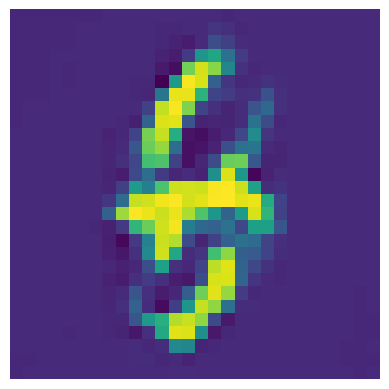

In [31]:
noize = torch.randn(1, NZ, device=DEVICE)
plt.imshow(netG(noize).squeeze().detach().numpy())
plt.axis(False)
plt.show()

## Conditional

Here, we consider a modification of the previous model. The model shown in this section will draw a picture of the given class.

In [4]:
# Generator's feature map
ngf = 64
# Input channels
nc = 1
# Size of the vector from which generator will create a picture
nz = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=10,
            embedding_dim=10
        )

        self.main = nn.Sequential(
            # (nz) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=nz+10,
                out_channels=ngf * 2, 
                kernel_size=7,
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # (nc) x 28 x 28
        )

    def forward(self, input, labels):
        ohe_labels = self.embedding(labels)[:, :, None, None]
        input = torch.cat([input, ohe_labels], dim=1)
        return self.main(input)

# Discriminator's feature map
ndf = 64

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=10, 
            embedding_dim=28 * 28
        )
        self.main = nn.Sequential(
            # (nc) x 28 x 28
            nn.Conv2d(
                in_channels=nc+1, 
                out_channels=ndf, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),


            # (ndf) x 14 x 14
            nn.Conv2d(
                in_channels=ndf, 
                out_channels=ndf * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),


            # (ndf*2) x 7 x 7
            nn.Conv2d(
                in_channels=ndf * 2, 
                out_channels=1,
                kernel_size=7, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.Sigmoid()
        )

    def forward(self, input, labels):
        labels = self.embedding(labels).reshape_as(input)
        input = torch.cat([input, labels], dim=1)
        return self.main(input)

In [5]:
netG = Generator().to(DEVICE)
netG = netG.apply(weights_init)

netD = Discriminator().to(DEVICE)
netD = netD.apply(weights_init)

criterion = nn.BCELoss()

lr = 0.001
beta1 = 0.5

# We'll draw images from the same input to compare results.
fixed_noise = torch.randn(64, nz, 1, 1, device=DEVICE)

# Labels for real and fake images
real_label, fake_label = 1., 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10

for epoch in range(num_epochs):
    for i, (X, y) in enumerate(DATA_LOADER, 0):
        real_batch = X.to(DEVICE)
        batch_size = real_batch.size(0)
        

        # Maximazing over discriminator log(D(x)) + log(1 - D(G(z)))
        # Step on the real image
        netD.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        output = netD(real_batch, y).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Step on the fake image
        noise = torch.randn(batch_size, nz, 1, 1, device=DEVICE)
        fake = netG(noise, y)
        label.fill_(fake_label)
        output = netD(fake.detach(), y).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Maximizing for generator log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake, y).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(DATA_LOADER),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(DATA_LOADER) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise, y).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

The following cell shows the result of the obtained network. In the `number` variable, you can specify the number to draw, and the result from the model will be displayed.

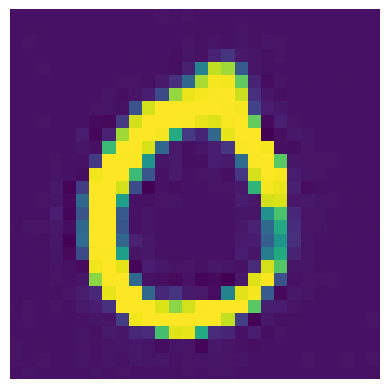

In [116]:
noise = torch.randn(1, nz, 1, 1, device=DEVICE)
number = 0

res = netG(
    noise, 
    torch.tensor([number])
)
plt.imshow(res.squeeze().detach().numpy())
plt.axis(False)
plt.show()